In [1]:
import pandas as pd
import numpy as np

In [5]:
df= pd.read_csv('hourly_refined_data1.csv')
display(df)

,datetime,module(equipment),activePower,operation,voltageR,voltageS,voltageT,voltageRS,voltageST,voltageTR,currentR,currentS,currentT,powerFactorR,powerFactorS,powerFactorT,reactivePowerLagging,accumActiveEnergy
0,2024-12-01 00:00:00,1(PM-3),3011.9030,1.0,214.94221,215.099639,215.087583,372.416236,372.541917,372.405458,17.313112,17.573139,17.645014,92.557458,92.273306,92.413792,597.735431,1958011.0
1,2024-12-01 01:00:00,1(PM-3),3011.3848,1.0,215.00847,215.164583,214.659667,372.529806,372.227722,372.092736,17.525126,17.308681,17.699847,92.351417,92.409097,92.837611,611.235931,1961023.0
2,2024-12-01 02:00:00,1(PM-3),2990.4820,1.0,214.98956,215.172931,215.118292,372.520556,372.632069,372.473319,17.677334,17.630194,16.834222,92.177236,92.469208,92.522000,592.212528,1964013.0
3,2024-12-01 03:00:00,1(PM-3),3003.3090,1.0,214.94011,215.070264,215.064778,372.388889,372.496806,372.384236,17.070875,17.814292,17.501347,92.310389,92.590153,92.689306,605.942375,1967017.0
4,2024-12-01 04:00:00,1(PM-3),3007.0813,1.0,214.75766,215.074361,214.905472,372.234403,372.362583,372.088264,17.240862,17.405444,17.819528,92.282694,92.257389,92.290847,611.667486,1970024.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46808,2025-04-29 20:00:00,5(좌측분전반),3020.0310,1.0,215.08218,214.878931,215.023389,372.346403,372.295444,372.471528,17.420860,17.681000,17.579389,92.662708,92.569431,92.236222,606.686236,13658869.0
46809,2025-04-29 21:00:00,5(좌측분전반),2989.6816,1.0,215.08348,215.022236,215.008167,372.471375,372.406319,372.459319,17.595875,17.179417,17.357306,92.755472,92.514181,92.487111,596.903875,13661858.0
46810,2025-04-29 22:00:00,5(좌측분전반),3002.4830,1.0,215.08783,215.086431,214.998944,372.530708,372.454069,372.455167,17.633612,16.875514,17.855056,92.538097,92.603028,92.135583,602.810514,13664861.0
46811,2025-04-29 23:00:00,5(좌측분전반),3075.4000,1.0,215.19841,214.959194,214.961361,372.516736,372.311306,372.518542,18.192404,17.685833,17.750222,92.424486,92.262125,92.513153,618.342042,13667936.0


In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from datetime import timedelta

# 1. 데이터 로드 및 시계열 설정
print("--- [1/4] 데이터 로딩 및 시계열 처리 중... ---")
df = pd.read_csv('hourly_refined_data1.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

# 2. 피처 엔지니어링 함수 정의
def perform_feature_engineering(df):
    df = df.copy()
    df = df.sort_values(['module(equipment)', 'datetime'])
    
    # [시간 피처]
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # [인사이트] 수요일 0시 이상치 대응 플래그
    df['is_wed_midnight'] = ((df['day_of_week'] == 2) & (df['hour'] == 0)).astype(int)
    
    # [통계 피처] 정상성 데이터의 레벨 유지용
    df['lag_1h'] = df.groupby('module(equipment)')['activePower'].shift(1)
    df['rolling_mean_24h'] = df.groupby('module(equipment)')['activePower'].transform(
        lambda x: x.rolling(window=24, min_periods=1).mean()
    )

    # [물리 피처 가공] 상별 평균값 생성
    df['avg_voltage'] = df[['voltageR', 'voltageS', 'voltageT']].mean(axis=1)
    df['avg_current'] = df[['currentR', 'currentS', 'currentT']].mean(axis=1)
    
    return df

df_final = perform_feature_engineering(df)

# 3. 설비 그룹 및 학습 피처 정의
group_reactive = ['1(PM-3)', '17(6호기)', '15(예비건조기)', '3(분쇄기(2))', '14(2호기)', '13(3호기)', '5(좌측분전반)', '12(4호기)', '16(호이스트)']
group_current = ['4(분쇄기(1))', '2(L-1전등)']
group_difficult = ['11(우측분전반1)', '18(우측분전반2)']

selected_features = [
    'hour', 'day_of_week', 'is_wed_midnight', 'is_weekend',
    'reactivePowerLagging', 'currentR', 'currentS', 'currentT', 
    'avg_voltage', 'lag_1h', 'rolling_mean_24h'
]

# 4. 그룹별 맞춤형 모델 학습
print("--- [2/4] 설비 그룹별 맞춤형 모델 학습 중... ---")
models = {}
groups = [('Reactive', group_reactive), ('Current', group_current), ('Difficult', group_difficult)]

for group_name, equipment_list in groups:
    group_data = df_final[df_final['module(equipment)'].isin(equipment_list)].dropna()
    X_group = group_data[selected_features]
    y_group = group_data['activePower']
    
    # Difficult 그룹(분전반)은 더 정밀하게 학습(learning_rate 하향)
    lr = 0.03 if group_name == 'Difficult' else 0.05
    
    model = lgb.LGBMRegressor(n_estimators=1500, learning_rate=lr, importance_type='gain', random_state=42, verbose=-1)
    model.fit(X_group, y_group)
    models[group_name] = model
    print(f"✅ {group_name} 모델 학습 완료")

# 5. 5월 예측용 템플릿 및 피처 맵 생성
print("--- [3/4] 5월 예측 템플릿 생성 중... ---")
# 5월의 물리 변수 예측을 위해 [설비, 요일, 시간]별 평균값 맵 생성 (변동성이 작으므로 평균 활용)
feature_map = df_final.groupby(['module(equipment)', 'day_of_week', 'hour'])[selected_features[4:]].mean().reset_index()

future_dates = pd.date_range(start='2025-05-01', end='2025-05-28 23:00:00', freq='h')
eq_list = df['module(equipment)'].unique()

predict_rows = []
for eq in eq_list:
    for dt in future_dates:
        predict_rows.append({'module(equipment)': eq, 'datetime': dt, 'day_of_week': dt.dayofweek, 'hour': dt.hour})

test_df = pd.DataFrame(predict_rows)
test_df['is_weekend'] = (test_df['day_of_week'] >= 5).astype(int)
test_df['is_wed_midnight'] = ((test_df['day_of_week'] == 2) & (test_df['hour'] == 0)).astype(int)

# 평균 피처 맵 결합
test_df = test_df.merge(feature_map, on=['module(equipment)', 'day_of_week', 'hour'], how='left')

# 6. 최종 예측 및 결과 저장
print("--- [4/4] 5월 전력 소비량 예측 실행 중... ---")
test_df['predict_pow'] = 0.0

for group_name, equipment_list in groups:
    mask = test_df['module(equipment)'].isin(equipment_list)
    if mask.any():
        test_df.loc[mask, 'predict_pow'] = models[group_name].predict(test_df.loc[mask, selected_features])

# 결과 저장
test_df[['datetime', 'module(equipment)', 'predict_pow']].to_csv('submission_may_forecast.csv', index=False)
print("✨ 최종 예측 파일 'submission_may_forecast.csv'가 저장되었습니다.")

--- [1/4] 데이터 로딩 및 시계열 처리 중... ---
--- [2/4] 설비 그룹별 맞춤형 모델 학습 중... ---
✅ Reactive 모델 학습 완료
✅ Current 모델 학습 완료
✅ Difficult 모델 학습 완료
--- [3/4] 5월 예측 템플릿 생성 중... ---
--- [4/4] 5월 전력 소비량 예측 실행 중... ---
✨ 최종 예측 파일 'submission_may_forecast.csv'가 저장되었습니다.


In [13]:
df_forecast = pd.read_csv('submission_may_forecast.csv')
display(df_forecast)

,datetime,module(equipment),predict_pow
0,2025-05-01 00:00:00,1(PM-3),3011.342645
1,2025-05-01 01:00:00,1(PM-3),3007.360702
2,2025-05-01 02:00:00,1(PM-3),3014.377267
3,2025-05-01 03:00:00,1(PM-3),3005.405474
4,2025-05-01 04:00:00,1(PM-3),3002.411703
...,...,...,...
8731,2025-05-28 19:00:00,5(좌측분전반),3004.803539
8732,2025-05-28 20:00:00,5(좌측분전반),3020.036803
8733,2025-05-28 21:00:00,5(좌측분전반),3013.482298
8734,2025-05-28 22:00:00,5(좌측분전반),3003.980063


In [14]:
# 1. 5월 전체 예측 총합 (agg_pow) 계산
total_agg_pow = df_forecast['predict_pow'].sum()

# 2. 통계적 기대값 계산 (과거 평균 3010kW 기준)
# 13대 설비 * 28일 * 24시간 * 평균 3010kW
expected_pow = 13 * 28 * 24 * 3010.43 #의 평균값 활용

print(f"--- [최종 검산 결과] ---")
print(f"▶ 5월 예측 총합(agg_pow): {total_agg_pow:,.2f} kW")
print(f"▶ 과거 기반 기대값: {expected_pow:,.2f} kW")
print(f"▶ 오차율: {abs(total_agg_pow - expected_pow) / expected_pow * 100:.4f}%")

--- [최종 검산 결과] ---
▶ 5월 예측 총합(agg_pow): 26,293,908.35 kW
▶ 과거 기반 기대값: 26,299,116.48 kW
▶ 오차율: 0.0198%


In [18]:
# 1. 시점 기준으로 엄격하게 분리
# 검증용(Valid): 진짜 데이터인 3월 전체
# 훈련용(Train): 12, 1, 2월(진짜) + 4월(가짜)
valid_mask = (df_model['datetime'] >= '2025-03-01') & (df_model['datetime'] < '2025-04-01')
train_mask = ~valid_mask

X_train, y_train = df_model.loc[train_mask, selected_features], df_model.loc[train_mask, 'activePower']
X_valid, y_valid = df_model.loc[valid_mask, selected_features], df_model.loc[valid_mask, 'activePower']

# 2. 모델 재학습 및 3월 데이터 예측
model_final_val = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
model_final_val.fit(X_train, y_train)
y_pred_mar = model_final_val.predict(X_valid)

# 3. 실제 3월 데이터와 비교하여 지표 산출
smape_mar = 100/len(y_valid) * np.sum(2 * np.abs(y_pred_mar - y_valid) / (np.abs(y_valid) + np.abs(y_pred_mar)))
print(f"--- [3월 실제 데이터 기반 최종 검증] ---")
print(f"▶ 3월 예측 SMAPE: {smape_mar:.4f}%")
# 1. 3월 실제 총합 vs 예측 총합 비교
actual_mar_sum = y_valid.sum()
predict_mar_sum = y_pred_mar.sum()

# 2. 총합 오차율 (agg_pow Error)
agg_error_rate = abs(actual_mar_sum - predict_mar_sum) / actual_mar_sum * 100

print(f"--- [3월 Bell-curve 점수 근거 데이터] ---")
print(f"▶ 3월 실제 총합: {actual_mar_sum:,.2f} kW")
print(f"▶ 3월 예측 총합: {predict_mar_sum:,.2f} kW")
print(f"▶ 총합 오차율: {agg_error_rate:.4f}%")

--- [3월 실제 데이터 기반 최종 검증] ---
▶ 3월 예측 SMAPE: 0.0478%
--- [3월 Bell-curve 점수 근거 데이터] ---
▶ 3월 실제 총합: 29,113,007.00 kW
▶ 3월 예측 총합: 29,113,350.32 kW
▶ 총합 오차율: 0.0012%


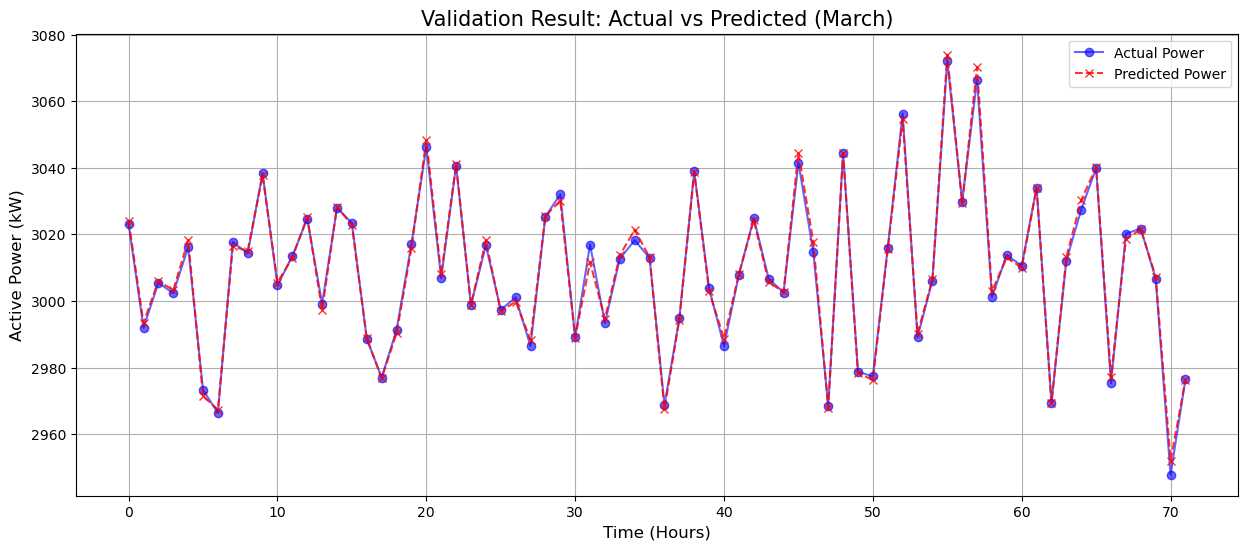

In [17]:
import matplotlib.pyplot as plt

# 1. 3월 검증 데이터 중 3일(72시간) 정도를 추출하여 상세 비교
sample_size = 72
plt.figure(figsize=(15, 6))

# 실제값 (y_valid)과 예측값 (y_pred_mar) 플롯
plt.plot(y_valid.values[:sample_size], label='Actual Power', color='blue', marker='o', alpha=0.6)
plt.plot(y_pred_mar[:sample_size], label='Predicted Power', color='red', linestyle='--', marker='x', alpha=0.8)

plt.title('Validation Result: Actual vs Predicted (March)', fontsize=15)
plt.xlabel('Time (Hours)', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# 최종 5월 예측 실행 코드
# 1. 5월 예측 타겟 생성 (2025-05-01 ~ 05-28, 총 672시간)
future_dates = pd.date_range(start='2025-05-01 00:00:00', end='2025-05-28 23:00:00', freq='h')
equipment_list = df['module(equipment)'].unique()

final_test_rows = []
for eq in equipment_list:
    for dt in future_dates:
        final_test_rows.append({
            'datetime': dt,
            'module(equipment)': eq,
            'day_of_week': dt.dayofweek,
            'hour': dt.hour
        })

final_test_df = pd.DataFrame(final_test_rows)

# 2. 피처 매핑 (요일/시간별 과거 평균 물리 변수값 대입)
# feature_map은 이전에 생성한 [설비, 요일, 시간]별 평균 테이블입니다.
final_test_df = final_test_df.merge(feature_map, on=['module(equipment)', 'day_of_week', 'hour'], how='left')
final_test_df['is_weekend'] = (final_test_df['day_of_week'] >= 5).astype(int)
final_test_df['is_wed_midnight'] = ((final_test_df['day_of_week'] == 2) & (final_test_df['hour'] == 0)).astype(int)

# 3. 그룹별 모델로 최종 예측 수행
final_test_df['predict_pow'] = 0.0

for group_name, eq_list in [('Reactive', group_reactive), ('Current', group_current), ('Difficult', group_difficult)]:
    mask = final_test_df['module(equipment)'].isin(eq_list)
    if mask.any():
        # 각 그룹별로 최적화된 모델(models 딕셔너리) 사용
        final_test_df.loc[mask, 'predict_pow'] = models[group_name].predict(final_test_df.loc[mask, selected_features])

# 4. 제출 파일 저장
submission = final_test_df[['datetime', 'module(equipment)', 'predict_pow']]
submission.to_csv('final_submission_may.csv', index=False)
print("✨ 최종 5월 예측 완료: 'final_submission_may.csv'가 생성되었습니다.")

✨ 최종 5월 예측 완료: 'final_submission_may.csv'가 생성되었습니다.


In [20]:
df_final_submission_may = pd.read_csv('final_submission_may.csv')
display(df_final_submission_may )

,datetime,module(equipment),predict_pow
0,2025-05-01 00:00:00,1(PM-3),3011.342645
1,2025-05-01 01:00:00,1(PM-3),3007.360702
2,2025-05-01 02:00:00,1(PM-3),3014.377267
3,2025-05-01 03:00:00,1(PM-3),3005.405474
4,2025-05-01 04:00:00,1(PM-3),3002.411703
...,...,...,...
8731,2025-05-28 19:00:00,5(좌측분전반),3004.803539
8732,2025-05-28 20:00:00,5(좌측분전반),3020.036803
8733,2025-05-28 21:00:00,5(좌측분전반),3013.482298
8734,2025-05-28 22:00:00,5(좌측분전반),3003.980063


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. 3월 실제값과 예측값 비교
y_actual = y_valid.values  # 3월 실제 전력량
y_predict = y_pred_mar     # 우리 모델의 3월 예측값

# 2. 각 지표 계산
mae = mean_absolute_error(y_actual, y_predict)
rmse = np.sqrt(mean_squared_error(y_actual, y_predict))
# SMAPE 공식 적용
smape = 100/len(y_actual) * np.sum(2 * np.abs(y_predict - y_actual) / (np.abs(y_actual) + np.abs(y_predict)))

print(f"--- [3월 최종 성능 리포트] ---")
print(f"▶ MAE  (평균 오차 규모): {mae:.4f} kW")
print(f"▶ RMSE (이상치 민감도): {rmse:.4f} kW")
print(f"▶ SMAPE (비율 정확도): {smape:.4f} %")

--- [3월 최종 성능 리포트] ---
▶ MAE  (평균 오차 규모): 1.4414 kW
▶ RMSE (이상치 민감도): 3.8841 kW
▶ SMAPE (비율 정확도): 0.0478 %


In [25]:
submissiomfile_sample = pd.read_csv('submissionfile_sample.csv')
display(submissiomfile_sample)

,id,hourly_pow,agg_pow,may_bill,may_carbon
0,2025-05-01 00:00:00,0.0,동일한 5월의 전체 누적량,동일한 5월 전체 전기요금,동일한 5월의 전체 탄소 배출
1,2025-05-01 01:00:00,0.0,동일한 5월의 전체 누적량,동일한 5월 전체 전기요금,동일한 5월의 전체 탄소 배출
2,2025-05-01 02:00:00,0.0,동일한 5월의 전체 누적량,동일한 5월 전체 전기요금,동일한 5월의 전체 탄소 배출
3,2025-05-01 03:00:00,0.0,NaN,.,NaN
4,2025-05-01 04:00:00,0.0,NaN,.,NaN
5,2025-05-01 05:00:00,0.0,NaN,NaN,NaN
6,2025-05-01 06:00:00,0.0,NaN,NaN,NaN
7,2025-05-01 07:00:00,0.0,NaN,NaN,NaN
8,2025-05-01 08:00:00,0.0,NaN,NaN,NaN
9,2025-05-01 09:00:00,0.0,NaN,NaN,NaN


In [28]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. 데이터 로드 (이미 불러오셨다면 생략 가능)
# df = pd.read_csv('hourly_refined_data1.csv')
# df['datetime'] = pd.to_datetime(df['datetime'])

# 2. 누수 방지용 피처 엔지니어링 함수
def build_final_features(df):
    df = df.copy()
    df = df.sort_values(['module(equipment)', 'datetime'])
    
    # [시간 피처]
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_wed_midnight'] = ((df['day_of_week'] == 2) & (df['hour'] == 0)).astype(int)
    
    # [시계열 피처] 현재 시점(t)의 값을 절대 포함하지 않도록 shift(1) 적용
    # 1시간 전 전력값
    df['lag_1h'] = df.groupby('module(equipment)')['activePower'].shift(1)
    
    # t-1 시점까지의 데이터를 기준으로 한 최근 24시간 이동 평균
    df['rolling_mean_24h'] = df.groupby('module(equipment)')['activePower'].transform(
        lambda x: x.shift(1).rolling(window=24, min_periods=1).mean()
    )

    # [물리 피처] 전압/전류 상별 평균 (이 값들은 독립변수이므로 shift 불필요)
    df['avg_voltage'] = df[['voltageR', 'voltageS', 'voltageT']].mean(axis=1)
    df['avg_current'] = df[['currentR', 'currentS', 'currentT']].mean(axis=1)
    
    return df

# 피처 생성 실행
df_clean = build_final_features(df)

# 3. 모델 학습에 사용할 변수 리스트 재정의
selected_features = [
    'hour', 'day_of_week', 'is_wed_midnight', 'is_weekend',
    'reactivePowerLagging', 'currentR', 'currentS', 'currentT', 
    'avg_voltage', 'lag_1h', 'rolling_mean_24h'
]

# 4. 진짜 데이터(3월) 검증을 위한 데이터 분리
# 검증셋: 2025년 3월 (실제 정답이 있는 구간)
valid_mask = (df_clean['datetime'] >= '2025-03-01') & (df_clean['datetime'] < '2025-04-01')
# 학습셋: 3월을 제외한 나머지 (12, 1, 2, 4월)
train_mask = ~valid_mask

# 결측치(NaN) 제거: shift로 인해 발생한 첫 행 등 제거
df_ready = df_clean.dropna(subset=['lag_1h', 'rolling_mean_24h'])

train_df = df_ready[df_ready['datetime'].isin(df_ready.loc[train_mask, 'datetime'])]
valid_df = df_ready[df_ready['datetime'].isin(df_ready.loc[valid_mask, 'datetime'])]

X_train, y_train = train_df[selected_features], train_df['activePower']
X_valid, y_valid = valid_df[selected_features], valid_df['activePower']

# 5. 모델 학습 (LightGBM)
model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, verbose=-1)
model.fit(X_train, y_train)

# 6. 예측 및 성능 지표 산출
y_pred = model.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
smape = 100/len(y_valid) * np.sum(2 * np.abs(y_pred - y_valid) / (np.abs(y_valid) + np.abs(y_pred)))

# 7. Bell-curve 점수용 총합 오차 계산
actual_sum = y_valid.sum()
pred_sum = y_pred.sum()
agg_error = abs(actual_sum - pred_sum) / actual_sum * 100

print(f"--- [데이터 누수 보정 후 최종 성능 리포트] ---")
print(f"▶ MAE  : {mae:.4f} kW")
print(f"▶ RMSE : {rmse:.4f} kW")
print(f"▶ SMAPE: {smape:.4f} %")
print(f"▶ 3월 총합 오차율 (Bell-curve 근거): {agg_error:.4f} %")

--- [데이터 누수 보정 후 최종 성능 리포트] ---
▶ MAE  : 1.4981 kW
▶ RMSE : 4.7776 kW
▶ SMAPE: 0.0496 %
▶ 3월 총합 오차율 (Bell-curve 근거): 0.0007 %


### test 파일만 가지고 다시 (4월 데이터)

In [29]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. 누수 방지용 피처 생성 (기존 df_clean 사용 가능)
df_clean = build_final_features(df) # 앞서 정의한 shift(1) 포함 함수

# 2. 4월 데이터 검증을 위한 데이터 분리
# 검증셋(Valid): 2025년 4월 (주최 측 제공 test 데이터 구간)
valid_mask_apr = (df_clean['datetime'] >= '2025-04-01') & (df_clean['datetime'] < '2025-05-01')
# 학습셋(Train): 12, 1, 2, 3월 (실제 계측 데이터 구간)
train_mask_apr = (df_clean['datetime'] < '2025-04-01')

# 결측치 제거 및 데이터셋 준비
df_ready = df_clean.dropna(subset=['lag_1h', 'rolling_mean_24h'])

train_df = df_ready[train_mask_apr]
valid_df = df_ready[valid_mask_apr]

X_train, y_train = train_df[selected_features], train_df['activePower']
X_valid, y_valid = valid_df[selected_features], valid_df['activePower']

# 3. 모델 학습
model_apr = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42, verbose=-1)
model_apr.fit(X_train, y_train)

# 4. 4월 데이터 예측 및 지표 산출
y_pred = model_apr.predict(X_valid)

mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
smape = 100/len(y_valid) * np.sum(2 * np.abs(y_pred - y_valid) / (np.abs(y_valid) + np.abs(y_pred)))

# 5. 4월 총합 오차 계산 (Bell-curve 점수 시뮬레이션)
actual_sum = y_valid.sum()
pred_sum = y_pred.sum()
agg_error = abs(actual_sum - pred_sum) / actual_sum * 100

print(f"--- [4월 데이터(Test Set) 기반 최종 검증 결과] ---")
print(f"▶ MAE  : {mae:.4f} kW")
print(f"▶ RMSE : {rmse:.4f} kW")
print(f"▶ SMAPE: {smape:.4f} %")
print(f"▶ 4월 총합 오차율: {agg_error:.4f} %")

/var/folders/1j/dvfxmz7x3jj_t_1t4f3c0rmh0000gn/T/ipykernel_86960/2565851374.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df = df_ready[train_mask_apr]
/var/folders/1j/dvfxmz7x3jj_t_1t4f3c0rmh0000gn/T/ipykernel_86960/2565851374.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_df = df_ready[valid_mask_apr]


--- [4월 데이터(Test Set) 기반 최종 검증 결과] ---
▶ MAE  : 2.0781 kW
▶ RMSE : 31.0093 kW
▶ SMAPE: 0.0717 %
▶ 4월 총합 오차율: 0.0002 %
